## Library Load

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA_m
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA_m
from sklearn.linear_model import LogisticRegression as LR_m
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np ,  pandas as pd

## SCENARIO

<br>

<div>

1. $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum) \quad $  $k = (1,2)$ <br>
2.  $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov = \begin{pmatrix} 1 & -0.5 \\ -0.5 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum) \quad $  $k = (1,2)$ <br>
3. $x_{i1} , x_{i2} \sim t(15) \quad $  ${-\frac{1}{2} \choose -\frac{1}{2}} + {x_{i1} \choose x_{i2}}_{i=1,...,50} \quad $ ${\frac{1}{2} \choose \frac{1}{2}} + {x_{i1} \choose x_{i2}}_{i=51,...,100}$  <br>
4. $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov_1 = \begin{pmatrix} 1 & -0.5 \\ -0.5 & 1 \end{pmatrix} \quad$ ,   $cov_2 = \begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum_k)_{k=1,2} \quad $  <br>
5. $x_1 \sim N(0,1) \quad x_2 \sim N(0,1) \quad P(x_i) = \frac{1}{1+ exp(+5x_{1i}^2-5x_{2i}^2 + x_1x_2)} \quad y_i \sim Ber(1, P(x_i))$ <br>
6. $x_1 \sim N(0,1) \quad x_2 \sim N(0,1) \quad P(x_i) = \frac{1}{1+ exp(-sin(x_{1i})+ \frac{1}{2}sin(\frac{1}{2}x_1 x_2) + x_2)} \quad y_i \sim Ber(1, P(x_i))$ <br>

</div>

In [8]:
def error_print(f , test_input , test_target) :
    error = 1 - sum(f.predict(test_input) == test_target) / len(test_target)
    return error

def Scenario_collection(number=1 , size_n = None, mean_1 = None ,mean_2 = None  ,
             cov_1 = None  , cov_2 = None  , t = 2) :
    if number in [1,2,4] :
        x1     = np.random.multivariate_normal(mean = mean_1, 
                                               cov  = cov_1, size = size_n)
        x2     = np.random.multivariate_normal(mean = mean_2, 
                                               cov  = cov_2, size = size_n)
        Input  = np.concatenate((x1,x2), axis = 0)
        target = [1]*size_n + [0]*size_n
    elif number in [3] :
        x1     = np.random.standard_t(t , size=(size_n,2)) + [-0.5,-0.5]
        x2     = np.random.standard_t(t , size=(size_n,2)) + [0.5,0.5]
        Input  = np.concatenate((x1,x2), axis = 0)
        target = [1] * size_n + [0] * size_n
    elif number in [5] :
        x1    = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x2    = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x1x2  = np.multiply(x1 ,x2)[:,np.newaxis]
        x1_2  = np.square(x1)[:,np.newaxis]
        x2_2  = np.square(x2)[:,np.newaxis]
        Input = np.hstack((x1_2, x1x2 , x2_2))
        p     =  1/(1+np.exp(+5*x1_2 -x2_2 + 5*x1x2))
        target = []
        for i in np.squeeze(p).tolist() :
            r = bernoulli.rvs(p = i , size= 1)[0]
            target.append(r)
    elif number in [6] :
        x1   = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x2   = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x1x2 = np.multiply(x1 ,x2)
        p    = 1/(1+np.exp(-(-np.sin(x1) +0.5*np.sin(0.5*x1x2) + x2)))
        target = []
        for i in np.squeeze(p).tolist() :
            r = bernoulli.rvs(p = i , size= 1)[0]
            target.append(r)
        x1    = x1[:,np.newaxis]
        x2    = x2[:,np.newaxis]
        x1x2  = x1x2[:,np.newaxis]
        Input = np.hstack((x1, x1x2 , x2))
    return Input , target

def compute(Scenario , number , mean_1 , mean_2 , cov_1 , cov_2 ) :
    cv_scores = []
    Input , target = Scenario(number = number , size_n = 50 , mean_1 = mean_1 ,mean_2 = mean_2  ,
             cov_1 = cov_1  , cov_2 = cov_2)
    # perform 5-fold cross validation
    for k in np.arange(1,20) :
        knn    = KNN(n_neighbors=k)
        scores = cross_val_score(knn, Input, target, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    print("Cross Validation Optimal K : {}".format(np.arange(1,20)[np.argmax(cv_scores)]))
    LDA    = LDA_m()
    QDA    = QDA_m()
    LR     = LR_m()
    knn_cv = KNN(n_neighbors = np.arange(1,20)[np.argmax(cv_scores)])
    knn_1  = KNN(n_neighbors = 1)

    knn_1_error  = []
    knn_cv_error = []
    lda_error    = []
    qda_error    = []
    lr_error     = []
    
    for _ in np.arange(100) :
        ## Data Generate
        train_input , train_target = Scenario(number = number , size_n = 100, mean_1 = mean_1 ,mean_2 = mean_2  ,
                                              cov_1 = cov_1  , cov_2 = cov_2)
        test_input , test_target   = Scenario(number = number , size_n = 5000, mean_1 = mean_1 ,mean_2 = mean_2  ,
                                              cov_1 = cov_1  , cov_2 = cov_2)
        ## Model Fitting
        LDA.fit(train_input , train_target)
        QDA.fit(train_input , train_target)
        LR.fit(train_input , train_target)
        knn_1.fit(train_input , train_target)
        knn_cv.fit(train_input , train_target)
        ## Predict
        error = error_print(knn_1 , test_input , test_target)
        knn_1_error.append(error)
        error = error_print(knn_cv , test_input , test_target)
        knn_cv_error.append(error)
        error = error_print(LDA , test_input , test_target)
        lda_error.append(error)
        error = error_print(QDA , test_input , test_target)
        qda_error.append(error)
        error = error_print(LR , test_input , test_target)
        lr_error.append(error)
        
    return knn_1_error , knn_cv_error , lda_error , qda_error , lr_error

def vis(Output, subplot  , title_n) :
    error_store     = Output
    name_store      = [["knn-1"]*100 + 
                       ["knn-cv"]*100 + 
                       ["LDA"]*100 + 
                       ["Logistic"]*100  + 
                       ["QDA"]*100]
    output          = pd.DataFrame(error_store + name_store).T
    output.columns  = ["error", "name"]
    output["error"] = output["error"].astype(float)
    sns.boxplot(data=output , x = "name" ,  y = "error" , ax = subplot).set_title("SCENARIO {}".format(title_n))

Cross Validation Optimal K : 4
Cross Validation Optimal K : 4
Cross Validation Optimal K : 14
Cross Validation Optimal K : 11
Cross Validation Optimal K : 7
Cross Validation Optimal K : 9


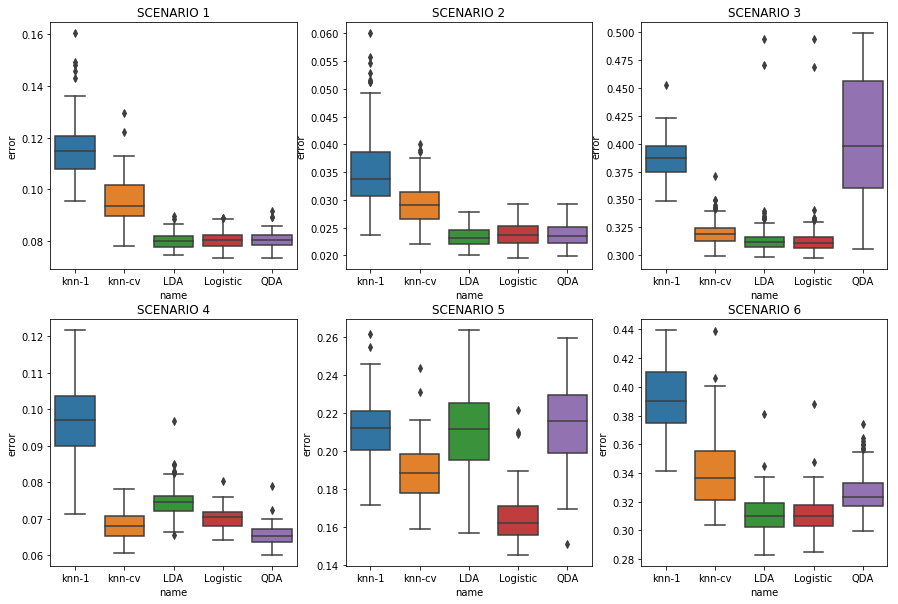

CPU times: user 29min 16s, sys: 42min 40s, total: 1h 11min 56s
Wall time: 16min 34s


In [9]:
%%time

f, ax = plt.subplots( 2,  3, figsize=(15, 10))
## 1
mean_1 , cov_1 = [-1,-1]  , [[1,0],[0,1]]
mean_2 , cov_2 = [1,1]  , [[1,0],[0,1]]

knn_1_error,knn_cv_error,lda_error,qda_error,lr_error =\
compute(Scenario_collection , 1 , 
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S1 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S1 , ax.flatten()[0], 1)
## 2
mean_1 , cov_1 = [-1,-1]  , [[1,-0.5],[-0.5,1]]
mean_2 , cov_2 = [1,1]  , [[1,-0.5],[-0.5,1]]
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error =\
compute(Scenario_collection , 2,
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S2 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S2 ,ax.flatten()[1],2)
## 3

knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 3, 
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S3 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S3 , ax.flatten()[2], 3)

## 4
mean_1 , cov_1 = [-1,-1]  , [[1,-0.5],[-0.5,1]]
mean_2 , cov_2 = [1,1]  , [[1,0.5],[0.5,1]]
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 4 , 
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S4 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S4 , ax.flatten()[3] , 4)

## 5
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 5 , 
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S5 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S5 ,ax.flatten()[4] ,5)

##6
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 6, 
        mean_1 = mean_1 ,mean_2 = mean_2  ,
        cov_1 = cov_1  , cov_2 = cov_2)
S6 = [knn_1_error + knn_cv_error + lda_error  + lr_error + qda_error]
vis(S6 , ax.flatten()[5] ,6)
plt.show()